In [2]:
import numpy as np
import torch.nn as nn
import torch

In [3]:
rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

In [4]:
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

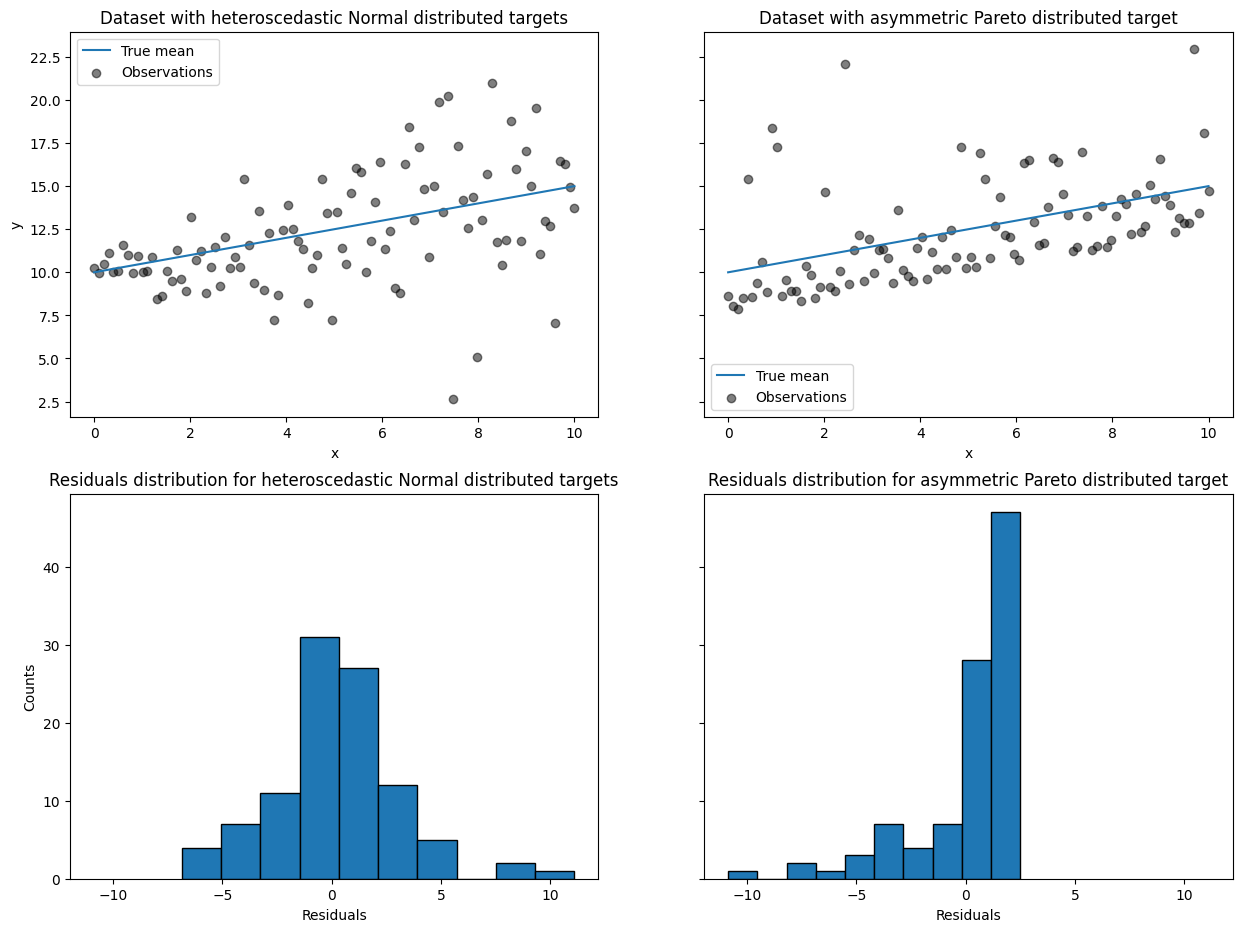

In [5]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

In [6]:
def tilted_loss(q, y, f):
    e = (y-f)
    return torch.mean(torch.max(q*e, (q-1)*e), dim=-1)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
X_train = torch.from_numpy(X)
y_train = torch.from_numpy(y_normal)

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]

input_size = 1
hidden_size = 64
output_size = 1

lr = 1e-2
num_epochs = 5000

models = [nn.Sequential(
            nn.Linear(input_size, output_size)
        ).double() for q in quantiles]

opts = [torch.optim.Adam(model.parameters(), lr=lr)
       for model in models]

In [14]:
quantile_loss = np.zeros(len(quantiles))

# Training loop
for epoch in range(num_epochs):

    for j, (q, model, opt) in enumerate(zip(quantiles, models, opts)):

        model = model.train()

        # Zero the parameter gradients
        opt.zero_grad()

        # Forward pass
        y_pred = model(X_train)
    
        # Calculate loss
        loss = tilted_loss(q, y_train, y_pred[:, 0])
    
        # Backward pass and optimization
        loss.backward()
        opt.step()
        quantile_loss[j] = loss.item()
    
    # Print statistics
    print(f'[{epoch + 1}] loss: {quantile_loss}')
    # print('[%d] loss: %.3f' %
    #         (epoch + 1, running_loss))

print('Finished Training')

[1] loss: [ 0.50550467  2.80946756  3.84266446 12.24979788  9.31871795]
[2] loss: [ 0.50335215  2.79446756  3.81546951 12.20479788  9.26256542]
[3] loss: [ 0.50119962  2.77946756  3.78827457 12.15979789  9.2064129 ]
[4] loss: [ 0.4990471   2.76446756  3.76107962 12.11479789  9.15026037]
[5] loss: [ 0.49689457  2.74946756  3.73388467 12.06979789  9.09410785]
[6] loss: [ 0.49474205  2.73446756  3.70668972 12.02479789  9.03795532]
[7] loss: [ 0.49258952  2.71946756  3.67949477 11.97979789  8.9818028 ]
[8] loss: [ 0.490437    2.70446756  3.65229982 11.93479789  8.92565027]
[9] loss: [ 0.48828447  2.68946756  3.62510487 11.88979789  8.86949775]
[10] loss: [ 0.48613195  2.67446756  3.59790992 11.84479789  8.81334522]
[11] loss: [ 0.48397942  2.65946756  3.57071497 11.79979789  8.7571927 ]
[12] loss: [ 0.48224476  2.64446756  3.54352002 11.75479789  8.7015027 ]
[13] loss: [ 0.48102821  2.62949269  3.51632507 11.70979789  8.64629786]
[14] loss: [ 0.47984346  2.6153873   3.48913012 11.66479789 

In [20]:
y_pred_list = []

for j, (q, model) in enumerate(zip(quantiles, models)):
    model = model.eval()
    y_pred_list.append(model(X_train).detach().numpy())

y_pred = np.concatenate(y_pred_list, axis=1)

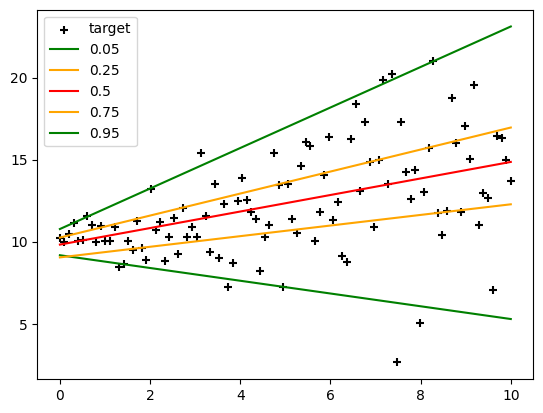

In [21]:
colors = ['green', 'orange', 'red', 'orange', 'green']
plt.scatter(X, y_normal, color='black', marker='+', label='target')

for i, q in enumerate(quantiles):
    plt.plot(X, y_pred[:, i], color=colors[i], label=q)

plt.legend()

In [22]:
quantile_loss

array([0.30455214, 0.85262921, 1.04641965, 0.83028845, 0.24904181])